In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from dstl.unet import unet

Using TensorFlow backend.


In [3]:
model = unet('unet_checkpoint.hdf5', input_size=(256, 256, 3), num_classes=5)

load weights 'unet_checkpoint.hdf5' MD5: aa739bce8aac397cbbe1f6b8cef18a84


In [4]:
from dstl.data_util import data_store
from dstl.preprocessing import truncate_as_float32, clip_to_tile

In [5]:
def get_data(image_id, target_size=(256, 256)):
    x = clip_to_tile(truncate_as_float32(data_store.raster_image(image_id, 'C')), target_size)
    y = clip_to_tile(data_store.mask_for_image_and_class(image_id, 'C', [1,2,3,4,5]), target_size)
    return x, y

In [6]:
def logits_to_mask(logits, num_classes=5):
    mask = np.zeros(logits.shape[:-1], dtype=np.uint8)
    class_logits = [np.squeeze(x) for x in np.split(logits, num_classes, axis=-1)]
    for idx, class_mask in enumerate(class_logits):
        mask[class_mask>0.5] = idx + 1
    return mask

In [7]:
from itertools import product
def join_tiles(tiles):
    rows, cols, h, w = tiles.shape[:4]
    rv = np.zeros((rows * h, cols * w, *tiles.shape[4:]), dtype=tiles.dtype)
    for r, c in product(range(rows), range(cols)):
        y_s, y_e = r * h, r * h + h
        x_s, x_e = c * w, c * w + w
        rv[y_s: y_e, x_s: x_e] = tiles[r, c]
    return rv

In [8]:
x, y = get_data('6100_1_3')

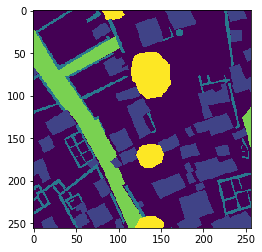

In [9]:
plt.imshow(logits_to_mask(y[0, 0]))

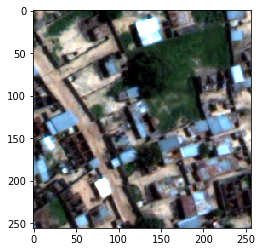

In [10]:
plt.imshow(join_tiles(x)[:256, :256])

In [11]:
pred = np.squeeze(model.predict(np.expand_dims(x[0, 0], axis=0)))

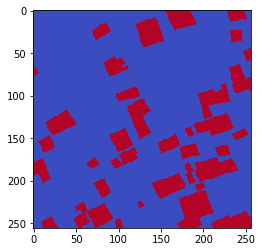

In [12]:
plt.imshow(y[0, 0][..., 0], cmap='coolwarm')

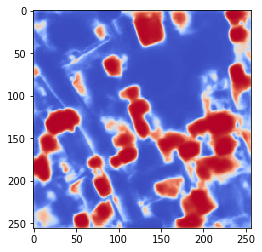

In [13]:
plt.imshow(pred[..., 0], cmap='coolwarm')